In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools
plt.rcParams['text.usetex']=True

# 0. Loading the data

In [2]:
pre_dfRegNet = pd.read_csv('tableData.csv')  
dfRegNet = pre_dfRegNet[pd.notna(pre_dfRegNet['3)RegulatorGeneName'])] #dropping NaN 
print(dfRegNet.shape)

(6975, 7)


- 0 `1)regulagtorID` = TF, node-A 
- 1 `2)regulaotorName` = TF's name. 
- 2 `3)RegulatorGeneName` = TF's gene's name, *A-label*
- 3 `4)regulatedId` = gene regulated. node-B 
- 4 `5)regulatedName` = gene's name, *B-label*
- 5 `6)funciton` = type of regylation
- 6 `7)confidenceLevel` = confirmed/strong/weak/unknown

In [3]:
mutuals_genes = list(set(dfRegNet['3)RegulatorGeneName']) & set(dfRegNet['5)regulatedName']))
print(len(mutuals_genes))

239


In the original file from RegulonDB, there are some `NaN` values in the `3)RegulatorGeneName`. This is probably because we don't know which gene produces those particular transcription factos. Due to this we discarded such genes, otherwise we would need to create a `NaN` node in our network, which further complicate issues. 
<!-- 
The cell below checks for mutual elements in the genes responsible for production of TFs and the ones they regulate, and there are 239 such genes.  -->

# 1. Directed graph of *E.coli* transcriptional regulatory network

In [4]:
#DiGraph g
regnet = dfRegNet.loc[:, ['3)RegulatorGeneName', '5)regulatedName']]
g  = nx.DiGraph()
g.add_edges_from(regnet.values)

# 2. Basic Statistics

In [5]:
print(f'#Nodes = {len(g.nodes)}')
print(f'#Edges = {len(g.edges)}')
print(f'#Self-loops = {nx.number_of_selfloops(g)}')

#Nodes = 2813
#Edges = 6975
#Self-loops = 153


In [6]:
in_degrees = [d for n, d in g.in_degree()]
out_degrees = [d for n, d in g.out_degree()]

print(f'<in-degree> = {np.mean(in_degrees)}')
print(f'<out-degree> = {np.mean(out_degrees)}')

<in-degree> = 2.4795591894774263
<out-degree> = 2.4795591894774263


Text(0.5, 1.0, 'Out-degree Distribution')

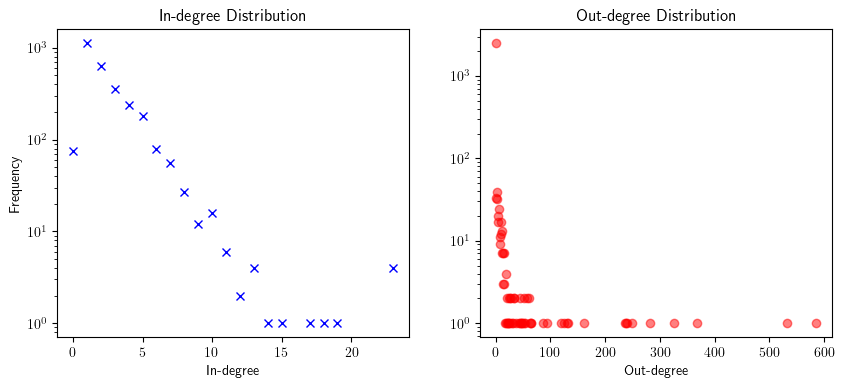

In [7]:
indg, indg_counts = np.unique(np.array(in_degrees), return_counts=True)
outdg, outdg_counts = np.unique(np.array(out_degrees), return_counts=True)

degreedist, axd = plt.subplots(1, 2, figsize=(10, 4))
# plt.figure(figsize=(4, 4))
axd[0].plot(indg, indg_counts,'x', color='blue', alpha=1)
axd[0].set_yscale('log')  
axd[0].set_xlabel("In-degree")
axd[0].set_ylabel("Frequency")
axd[0].set_title("In-degree Distribution")

axd[1].plot(outdg, outdg_counts,'o', color='red', alpha=0.5)
axd[1].set_yscale('log')  
axd[1].set_xlabel("Out-degree")
axd[1].set_title("Out-degree Distribution")

In [8]:

hub5 = sorted(g.out_degree(), key=lambda x: x[1])[-5:]
print(f'Hubs: {hub5}')


Hubs: [('fur', 282), ('fnr', 326), ('lrp', 368), ('nac', 532), ('crp', 585)]


# 3. Three-Node Motifs

In [26]:

def all_3_node_digraphs():
    nodes = [0, 1, 2]
    edge_list = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
    all_graphs = []

    for edges in itertools.product([0, 1], repeat=6):
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        for i, edge_here in enumerate(edges):
            if edge_here:
                g.add_edge(*edge_list[i])
        all_graphs.append(g)

    return all_graphs

node3_digraphs = all_3_node_digraphs()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

# Define nodes and all directed edges excluding self-loops
nodes = [0, 1, 2]
edges = [(i, j) for i in nodes for j in nodes if i != j]  # 6 directed edges

# Generate all 2^6 = 64 combinations of edges (presence/absence)
edge_combinations = list(product([0, 1], repeat=len(edges)))

# Set up 8x8 subplots
fig, axl = plt.subplots(8, 8, figsize=(16, 16))
axl = axl.flatten()

for i, bits in enumerate(edge_combinations):
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from([e for b, e in zip(bits, edges) if b])

    ax = axl[i]
    ax.set_axis_off()
    # ax.set_title(f"#{i + 1}", fontsize=8)

    pos = nx.circular_layout(g)
    nx.draw_networkx_nodes(g, pos, ax=ax, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(g, pos, ax=ax)

    # Draw arrows with curved edges to distinguish direction
    nx.draw_networkx_edges(
        g, pos, ax=ax, arrows=True,
        connectionstyle='arc3,rad=0.2',
        arrowstyle='-|>', min_target_margin=5
    )

plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import itertools
from collections import Counter
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Make sure you have your main graph
G = g  # assuming g is your existing DiGraph

# Step 1: Extract all unique 3-node subgraphs (as node sets)
subgraph_node_sets = list(itertools.combinations(G.nodes, 3))

# Step 2: Generate all 3-node directed motifs
def generate_all_3_node_digraphs():
    motifs = []
    nodes = [0, 1, 2]
    edge_list = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
    for edges in itertools.product([0, 1], repeat=6):
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        for i, flag in enumerate(edges):
            if flag:
                g.add_edge(*edge_list[i])
        motifs.append(g)
    return motifs

motif_types = generate_all_3_node_digraphs()

# Step 3: Define a function to classify a subgraph
def classify_subgraph(nodes):
    sg = G.subgraph(nodes).copy()
    for i, motif in enumerate(motif_types):
        if nx.is_isomorphic(sg, motif): 
            return i
    return None  # should not happen unless a bug

# Step 4: Run in parallel
with ProcessPoolExecutor() as executor:
    motif_ids = list(tqdm(executor.map(classify_subgraph, subgraph_node_sets),
                          total=len(subgraph_node_sets),
                          desc="Parallel motif counting"))

# Step 5: Count and report
motif_counts = Counter(motif_ids)
for motif_id, count in motif_counts.items():
    print(f"Motif {motif_id}: {count} occurrences")


NameError: name 'g' is not defined